# 단열선도 그리기

CAPE, CIN 영역 포함

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
from metpy.plots import SkewT
import metpy.calc as mpcalc
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [35]:
dt = datetime(2019, 9, 7, 12)
station = 'RKSO'

# 'RKSO': 오산
# 'RKSP': 백령도
# 'RKTH': 포항
# 'RKTD': 대전
# 'RKJJ': 광주
# 'RKPC': 제주
# 'RKNN': 강릉

In [36]:
# Read remote sounding data based on time (dt) and station
df = WyomingUpperAir.request_data(dt, station)
#df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all'
#               ).reset_index(drop=True)

# Create dictionary of united arrays
data = pandas_dataframe_to_unit_arrays(df)

In [37]:
# Isolate united arrays from dictionary to individual variables
p = data['pressure']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']

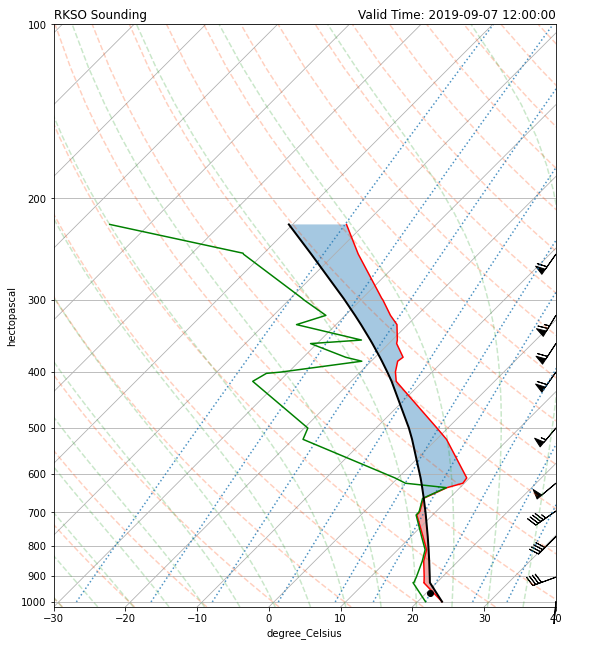

In [38]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof)
skew.shade_cape(p, T, prof)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right');